In this notebook we will test features common to ABP and ICP signals.

In [24]:
 # Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import signal 
import pandas as pd

# Tools for statistics
from scipy import stats
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import cluster
from statsmodels.formula.api import ols
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind,mannwhitneyu
import seaborn as sns


# Tools from brainsignal library
import os
import sys
path=r'C:\Users\Hamon\Documents\Stage\brainsignal'
sys.path.append(path)
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.postprocessing as pp

# This makes the plots appear inside the notebook
%matplotlib inline

## Load data

### ABP data

In [43]:
rep='../../data/'
patientdir='ID_2'

file=glob.glob(rep+patientdir+'/WAVE_ABP.txt', recursive=True)[0]

data=pd.read_csv(file,header=None, decimal=',', delimiter='\n')
data_array=np.array(data.values)
ABP_signal=data_array.transpose()[0]

In [44]:
fs=200
ABP_time=np.arange(len(ABP_signal))/fs

### ICP data

In [45]:
rep='../../data/'
patientdir='ID_2'

file=glob.glob(rep+patientdir+'/WAVE_ICP.txt', recursive=True)[0]

data=pd.read_csv(file,header=None, decimal=',', delimiter='\n')
data_array=np.array(data.values)
ICP_signal=data_array.transpose()[0]

In [46]:
fs=200
ICP_time=np.arange(len(ICP_signal))/fs

### Filter

In [47]:
rep='../../output/'
patientdir='ID_2'
study_name='widow5min'
file=glob.glob(rep+patientdir+study_name+'ABP.txt', recursive=True)[0]

data=pd.read_csv(file, decimal='.', delimiter='\t')

filt1=np.where((np.abs(data['Heart frequency (Hz)']-(1/(data['Mean RR (ms)']*1e-3)))/data['Heart frequency (Hz)']*100)<5)[0]

In [50]:
rep='../../output/'
patientdir='ID_2'
study_name='window5min'
file=glob.glob(rep+patientdir+study_name+'ICP.txt', recursive=True)[0]

data2=pd.read_csv(file, decimal='.', delimiter='\t')

filt2=np.where((np.abs(data['Heart frequency (Hz)']-data2['Heart frequency (Hz)'])/data2['Heart frequency (Hz)']*100)<10)[0]

### Correlation with Pearson's method

#### Time selection 

In [51]:
start=50000 #cond departure time 
duration=10 #second

indices=da.indexseq(start, duration, ABP_time)

Text(0.5, 1.0, 'Correlation between APB & ICP during 10 seconds')

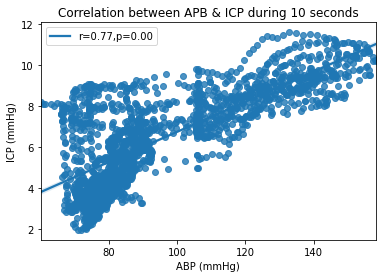

In [52]:
r, p = stats.pearsonr(ABP_signal[indices], ICP_signal[indices]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(x=ABP_signal[indices],y=ICP_signal[indices],ax=ax)
L=[l1]
plt.legend(L)
plt.xlabel('ABP (mmHg)')
plt.ylabel('ICP (mmHg)')
plt.title('Correlation between APB & ICP during 10 seconds')

We can distinguish tow different groups one under 100 mmHg and one higher. Let's separate these two groups.

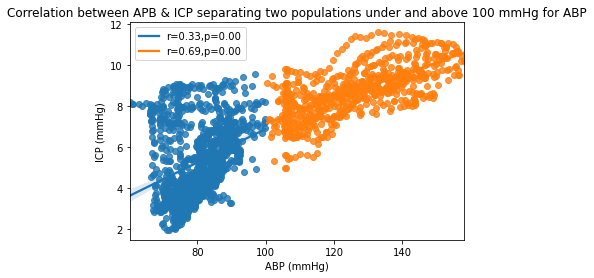

In [53]:
#separate in two groups for ABP, threshold = 100 mmHg

# group 1 
filter1=ABP_signal[indices]<=100

r, p = stats.pearsonr(ABP_signal[indices][filter1], ICP_signal[indices][filter1])

l1='r=%.2f,p=%.2f'%(r,p)

fig, ax = plt.subplots()
g=sns.regplot(x=ABP_signal[indices][filter1],y=ICP_signal[indices][filter1],ax=ax)

# group 2
filter2=ABP_signal[indices]>100

r, p = stats.pearsonr(ABP_signal[indices][filter2], ICP_signal[indices][filter2])

l2='r=%.2f,p=%.2f'%(r,p)

g=sns.regplot(x=ABP_signal[indices][filter2],y=ICP_signal[indices][filter2],ax=ax)

plt.title('Correlation between APB & ICP separating two populations under and above 100 mmHg for ABP')
L=[l1, l2]
plt.xlabel('ABP (mmHg)')
plt.ylabel('ICP (mmHg)')
plt.legend(L)

We can see that the two groups have a different correlation.

### CPP calculation for the same sample of data

In [89]:
cpp=np.mean(ABP_signal-ICP_signal)
cpp_std=np.std(ABP_signal-ICP_signal)

In [90]:
print('CPP=', cpp)
print('CPP STD=', cpp_std)

CPP= 96.17143786311811
CPP STD= 27.50699127549312


### During all night

Calculation on windows of 5 minutes every minutes.

In [56]:
rep='../../output/'
patientdir='ID_2'
study_name='widow5min'
file=glob.glob(rep+patientdir+study_name+'ABP_ICP.txt', recursive=True)[0]

data=pd.read_csv(file, decimal='.', delimiter='\t')

In [57]:
data

#time  Correlation  pvalue  CPP mean  CPP std      PRx  PRx p-val  \
0       180.0       0.6825     0.0    102.70    23.48  0.02377   0.858200   
1       240.0       0.6314     0.0    103.00    23.20 -0.25110   0.055050   
2       300.0       0.3009     0.0    109.80    43.73 -0.11420   0.389100   
3       360.0       0.2922     0.0    109.70    43.65 -0.14010   0.289800   
4       420.0       0.2446     0.0    115.60    54.37 -0.10530   0.427300   
...       ...          ...     ...       ...      ...      ...        ...   
1413  84960.0       0.7780     0.0     98.34    21.77  0.28240   0.030210   
1414  85020.0       0.7989     0.0     97.37    21.36  0.42440   0.000808   
1415  85080.0       0.8008     0.0     97.41    21.28  0.34920   0.006712   
1416  85140.0       0.8090     0.0     97.45    21.21  0.35420   0.005911   
1417  85200.0          NaN     NaN       NaN      NaN      NaN        NaN   

      Unnamed: 7  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
1413         NaN  
1414         NaN  
1415         NaN  
1416         NaN  
1417         NaN  

[1418 rows x 8 columns]

### Correlation 

Text(0.5, 1.0, 'Correlation between ABP & ICP during all night')

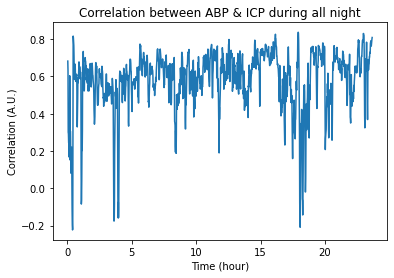

In [92]:
plt.plot(data['#time']/3600, data['Correlation'])
plt.xlabel('Time (hour)')
plt.ylabel('Correlation (A.U.)')
plt.title('Correlation between ABP & ICP during all night')

### P-value

Text(0.5, 1.0, 'P-value of correlation during all night')

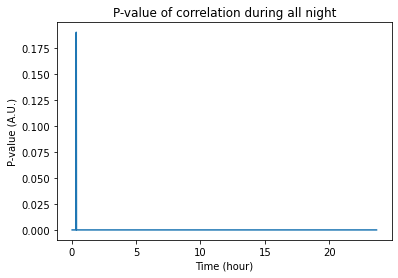

In [93]:
plt.plot(data['#time']/3600, data['pvalue'])
plt.xlabel('Time (hour)')
plt.ylabel('P-value (A.U.)')
plt.title('P-value of correlation during all night')

### CPP mean

Text(0.5, 1.0, 'CPP mean during all night')

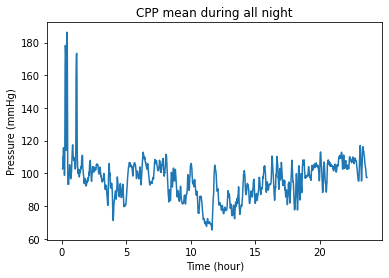

In [94]:
plt.plot(data['#time']/3600, data['CPP mean'])
plt.xlabel('Time (hour)')
plt.ylabel('Pressure (mmHg)')
plt.title('CPP mean during all night')

### CPP standard deviation

Text(0.5, 1.0, 'CPP standard deviation during all night')

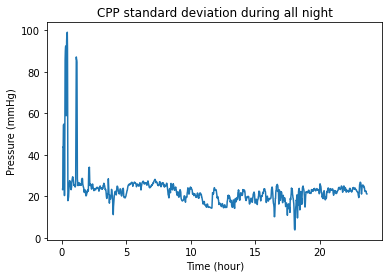

In [61]:
plt.plot(data['#time']/3600, data['CPP std'])
plt.xlabel('Time (hour)')
plt.ylabel('Pressure (mmHg)')
plt.title('CPP standard deviation during all night')

### PRx

Text(0.5, 1.0, 'PRx between ABP & ICP during all night')

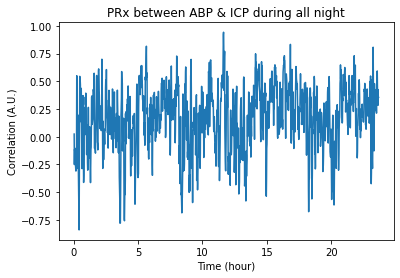

In [67]:
plt.plot(data['#time']/3600, data['PRx'])
plt.xlabel('Time (hour)')
plt.ylabel('Correlation (A.U.)')
plt.title('PRx between ABP & ICP during all night')

We can notice that the correlation is really changing during all night signals can be hightly correlated as they can have a lowly correlation. 